In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# Don't worry about what all these are -- used later
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [4]:
# let's build a really simple model: linear regression from 
# 2 inputs to a single float output

model = Sequential()
model.add(Dense(output_dim=1, input_dim=2))

# mean squared error regression, RMSprop optimizer
model.compile(loss='mse', optimizer='rmsprop')

Let's look at our model:

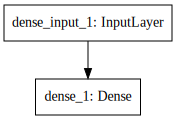

In [7]:
# (Note: I ran 
# pip install pydot==1.1.0 
# and pip install graphviz
# and installed the graphviz OS X package with binary libraries
# to get this to work. May not actually need the pydot downgrade...)
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Let's make up some data:

$y = 3a + 5b + N(0,1)$

where the last term is normally distributed error.

In [5]:
# Some magic to make numpy arrays look prettier
import contextlib
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [6]:
num_samples = 100
data = np.random.random((num_samples, 2))
noise = np.random.normal(size=num_samples)
values = 3 * data[:,0] + 5 * data[:,1] + noise

In [7]:
# Look at it:
with printoptions(precision=2, threshold=20):
    print data
    print noise
    print values

[[ 0.64  0.55]
 [ 0.86  0.84]
 [ 0.09  0.74]
 ..., 
 [ 0.37  0.88]
 [ 0.61  0.41]
 [ 0.97  0.52]]
[ 1.94  0.46 -0.43 ...,  2.13 -0.34 -0.07]
[ 6.64  7.26  3.51 ...,  7.62  3.53  5.45]


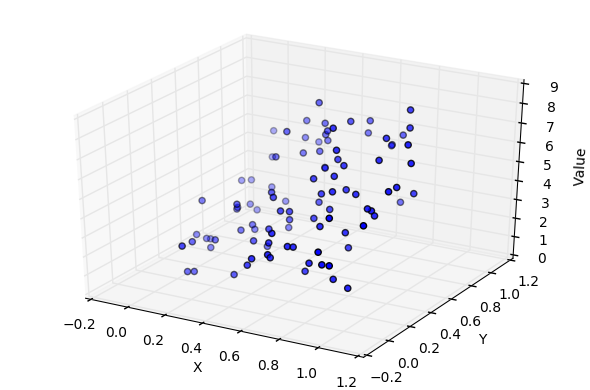

In [8]:
# and plot it 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=data[:,0], ys=data[:,1], zs=values)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
fig.tight_layout()

We can see that (as expected) the values lie roughly in a plane, so our model should do a good job...

Let's fit it!

In [ ]:
model.fit(data, values, nb_epoch=100, batch_size=32)

Epoch 1/1000
100/100 [==============================] - 0s - loss: 10.1532    
Epoch 2/1000
100/100 [==============================] - 0s - loss: 10.1134     
Epoch 3/1000
100/100 [==============================] - 0s - loss: 10.0761    
Epoch 4/1000
100/100 [==============================] - 0s - loss: 10.0344     
Epoch 5/1000
100/100 [==============================] - 0s - loss: 9.9946     
Epoch 6/1000
100/100 [==============================] - 0s - loss: 9.9460     
Epoch 7/1000
100/100 [==============================] - 0s - loss: 9.8980     
Epoch 8/1000
100/100 [==============================] - 0s - loss: 9.8550      
Epoch 9/1000
100/100 [==============================] - 0s - loss: 9.8169     
Epoch 10/1000
100/100 [==============================] - 0s - loss: 9.7709      
Epoch 11/1000
100/100 [==============================] - 0s - loss: 9.7308      
Epoch 12/1000
100/100 [==============================] - 0s - loss: 9.6950      
Epoch 13/1000
100/100 [====================

In [35]:
model.get_weights()

[array([[ 2.59551454],
        [ 3.13851881]], dtype=float32), array([ 1.29032826], dtype=float32)]

In [40]:
model.evaluate(data, values, batch_size=32)

 32/100 [========>.....................] - ETA: 0s

1.4298352289199829

Let's save the learned weights and use our "known" weights instead to see how they do

In [46]:
saved_weights = model.get_weights()
model.set_weights([np.array([[3], [5]]), np.array([0])])
model.evaluate(data, values)

 32/100 [========>.....................] - ETA: 0s

1.073939847946167

In [49]:
# What is the loss? Total over entire dataset? or average?
# Easy enough to find out:
deltas = values - (3 * data[:,0] + 5 * data[:,1])  # i.e. the noise
squared_deltas = np.square(deltas)
np.mean(squared_deltas)

1.0739398439538927

i.e. it's what we told Keras to use: MSE, or _Mean_ Squared Error

So, why did it take so long to learn? Because the learning rate is low, and the variable initialization isn't very good for our problem.

Let's try to tweak the optimizer:

In [63]:
model2 = Sequential()
model2.add(Dense(output_dim=1, input_dim=2))

optimizer = RMSprop(lr=0.1)
model2.compile(loss='mse', optimizer=optimizer)

In [64]:
model2.fit(data, values, nb_epoch=10, batch_size=32)

Epoch 1/10
100/100 [==============================] - 0s - loss: 15.1142     
Epoch 2/10
100/100 [==============================] - 0s - loss: 7.2967     
Epoch 3/10
100/100 [==============================] - 0s - loss: 4.1498     
Epoch 4/10
100/100 [==============================] - 0s - loss: 2.7060     
Epoch 5/10
100/100 [==============================] - 0s - loss: 2.2213     
Epoch 6/10
100/100 [==============================] - 0s - loss: 1.9073     
Epoch 7/10
100/100 [==============================] - 0s - loss: 1.6973     
Epoch 8/10
100/100 [==============================] - 0s - loss: 1.5989     
Epoch 9/10
100/100 [==============================] - 0s - loss: 1.5364     
Epoch 10/10
100/100 [==============================] - 0s - loss: 1.5185     


Aha -- higher learning rate certainly helps. Could also fiddle with initialization values: let's "cheat" and give it the exact "correct" values.

In [76]:
model3 = Sequential()
model3.add(Dense(output_dim=1, input_dim=2, 
                 weights=[np.array([[3],[5]]), np.array([0])]))

# reduced LR from model2 so it doesn't bounce around as much
optimizer = RMSprop(lr=0.01)  
model3.compile(loss='mse', optimizer=optimizer)

In [77]:
model3.evaluate(data, values, batch_size=32)

 32/100 [========>.....................] - ETA: 0s

1.073939847946167

In [78]:
model3.fit(data, values, nb_epoch=10, batch_size=32)

Epoch 1/10
100/100 [==============================] - 0s - loss: 1.0438     
Epoch 2/10
100/100 [==============================] - 0s - loss: 1.0352     
Epoch 3/10
100/100 [==============================] - 0s - loss: 1.0365     
Epoch 4/10
100/100 [==============================] - 0s - loss: 1.0362     
Epoch 5/10
100/100 [==============================] - 0s - loss: 1.0350     
Epoch 6/10
100/100 [==============================] - 0s - loss: 1.0326     
Epoch 7/10
100/100 [==============================] - 0s - loss: 1.0316     
Epoch 8/10
100/100 [==============================] - 0s - loss: 1.0319     
Epoch 9/10
100/100 [==============================] - 0s - loss: 1.0293     
Epoch 10/10
100/100 [==============================] - 0s - loss: 1.0284     


We started with the "correct" parameters used to generate the data, but the network keeps "learning" and getting lower training error. So even with just two parameters, we can _overfit_, get distracted by the noise. Validation sets will help... in a future notebook.